# Training Analysis

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## From Scratch

### Regular CNN

#### 4 classes

##### Learning Rate

(1e-08, 0.1, 1.0, 3.0)

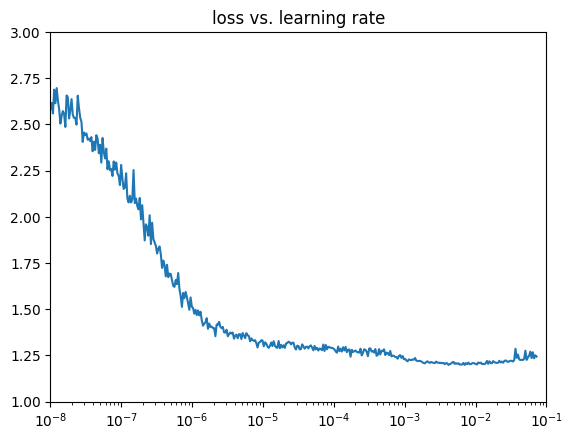

In [6]:
path_to_lr_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/numpy_histories/cutout/conv/history_00.npy")

history = np.load(path_to_lr_history, allow_pickle=True).item()

plt.semilogx(history["lr"], history["loss"])
plt.title("loss vs. learning rate")
plt.axis([1e-8, 1e-1, 1, 3])

While this graph isn't perfect, we can see that the loss gradually becomes less when the the learning rate is increased until roughly 10^-5. For the training I then used a lerning rate of 10^-6

##### Training results

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])


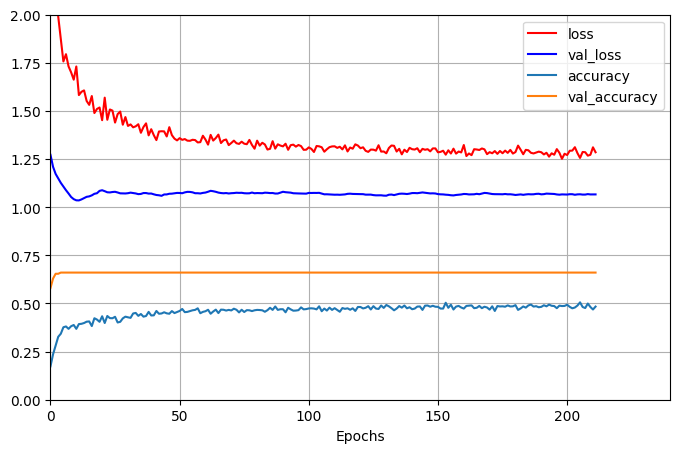

In [13]:
path_to_lr_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/numpy_histories/cutout/conv/convlr00_4_classes_run_2024_08_07_20_42_08/history.npy")

history = np.load(path_to_lr_history, allow_pickle=True).item()

print(history.keys())

pd.DataFrame(history)[["loss","val_loss", "accuracy","val_accuracy"]].plot(figsize=(8,5),
                           xlim=(0,240),
                           ylim=(0,2),
                           grid=True,
                           xlabel="Epochs",
                           style=["r-","b-"],)
plt.show()

### ResNet34 architecture

(1e-08, 0.1, 1.0, 3.0)

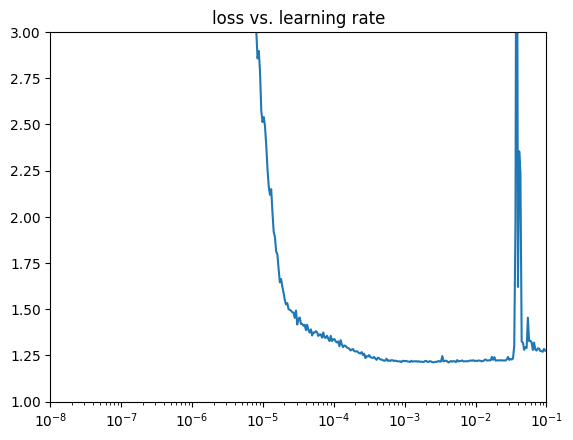

In [4]:
path_to_lr_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/numpy_histories/cutout/Resnet34/resnet34lr00_4_classes_run_2024_08_07_21_03_41/history.npy")

history = np.load(path_to_lr_history, allow_pickle=True).item()

plt.semilogx(history["lr"], history["loss"])
plt.title("loss vs. learning rate")
plt.axis([1e-8, 1e-1, 1, 3])

I guess I'll be using a learning rate of roughly 10^-4

### Resnet152 architecture

### ResNeXt Architecture

## Pre Trained